# HW 5 - Page Rank
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In Weeks 8 and 9 you discussed key concepts related to graph based algorithms and implemented SSSP.   
In this final homework assignment you'll implement distributed PageRank using some data from Wikipedia.
By the end of this homework you should be able to:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

__Please refer to the `README` for homework submission instructions and additional resources.__

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [0]:
%pip install networkx==2.5

Python interpreter will be restarted.
Collecting networkx==2.5
 Downloading networkx-2.5-py3-none-any.whl (1.6 MB)
Requirement already satisfied: decorator>=4.3.0 in /databricks/python3/lib/python3.8/site-packages (from networkx==2.5) (4.4.2)
Installing collected packages: networkx
Successfully installed networkx-2.5
WARNING: You are using pip version 20.2.4; however, version 21.1.3 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-4a600f10-8d9a-4466-8197-77b000c59073/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import json

### Run the next cell to create your directory in dbfs
You do not need to understand this scala snippet. It simply dynamically fetches your user directory name so that any files you write can be saved in your own directory.

In [0]:
# RUN THIS CELL AS IS
# This code snippet reads the user directory name, and stores is in a python variable.
# Next, it creates a folder inside your home folder, which you will use for files which you save inside this notebook.
username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
userhome = 'dbfs:/user/' + username
print(userhome)
hw5_path = userhome + "/HW5/" 
hw5_path_open = '/dbfs' + hw5_path.split(':')[-1] # for use with python open()
dbutils.fs.mkdirs(hw5_path)

dbfs:/user/abhisha@berkeley.edu
Out[2]: True

In [0]:
# RUN THIS CELL AS IS. 
tot = 0
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
for item in dbutils.fs.ls(DATA_PATH):
  tot = tot+item.size
tot
# ~4.7GB

Out[3]: 4751198766

In [0]:
# RUN THIS CELL AS IS. You should see all-pages-indexed-in.txt, all-pages-indexed-out.txt and indices.txt in the results. If you do not see these, please let an Instructor or TA know.
display(dbutils.fs.ls(DATA_PATH))

path,name,size
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt,all-pages-indexed-in.txt,2143300687
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt,all-pages-indexed-out.txt,2090459616
dbfs:/mnt/mids-w261/HW5/indices.txt,indices.txt,517438296
dbfs:/mnt/mids-w261/HW5/test_graph.txt,test_graph.txt,167


In [0]:
# RUN THIS CELL AS IS - A test to make sure your directory is working as expected.
# You should see a result like:
# dbfs:/user/youremail@ischool.berkeley.edu/HW5/test.txt
dbutils.fs.put(hw5_path+'test.txt',"hello world",True)
display(dbutils.fs.ls(hw5_path))


Wrote 11 bytes.

path,name,size
dbfs:/user/abhisha@berkeley.edu/HW5/test.txt,test.txt,11


In [0]:
sc = spark.sparkContext
spark

Out[6]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.1 
 Master 
 spark://10.0.128.13:7077 
 AppName 
 Databricks Shell

# Question 1: Distributed Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concernts that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading and your async lectures. 

### Q1 Tasks:

* __a) short response:__ Give an example of a dataset that would be appropriate to represent as a graph. What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? What would the average "in-degree" of a node mean in the context of your example? 

* __b) short response:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm? *(__HINT__: Do not respond in terms of any specific algorithm. Think in terms of the nature of the graph datastructure itself).*

* __c) short response:__ Briefly describe Dijskra's algorithm (goal/approach). What specific design component makes this approach hard to parallelize?

* __d) short response:__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?

### Q1 Student Answers:
> __a)__ One example would be social networks, such as Facebook - which contains billions of nodes and trillions of edges today. Here, the node will represent the Facebook user. Note that the `node` may itself contain several pieces of metadata that identifies the user - demographics (age, gender, name, location), node ID (username). The `edge` would represent the link to other users, ie, their friendship status. Note that the edge also may have several pieces of metadata associated with it - type of connection (friend, spouse, sibling), the time length of the edge (how long the 2 nodes have been associated). In a network of N individuals, there are `n(n-1)` possible friendships. This is a potential problem when we are talking about N being in the order of billions of individuals. However, in reality these graphs are much smaller in terms of number of connections because - even the most "social" individuals will have few friends compared to the size of the network itself. In our facebook example, the graph would be undirected since the friendship is bidirectional. However, there very well could be directional links too - think of a case in Instagram where user A follows user B, but not vice versa. The `in-degree` of the node is the summation of all the edges that are incoming to it. In-Degree is a property only of directed graphs. Thus, this property would not make much sense in our friendship graph since we established that friendship is bi-directional. In the Facebook example, we can consider directionality if we consider that user A likes (follows) topic pages - say user A follows a set of sample pages - institutions (UC Berkeley, WHO), celebrities (Dwayne Johnson, Bill Gates), or music groups (Beyonce, Metallica). In this sense, these topic pages that have many fans (followers) would have a high number of in-degree connections (edges). For example, `Dwayne Johnson` has a collective in-degree score of 58M followers today (https://www.facebook.com/DwayneJohnson) 

> __b)__ One of the main challenges to "dividing and conquering" computations involving graphs is that the fundamental units of analysis (nodes and edges) carry information about each other so it often takes some careful planning to making sure that the appropriate information is co-located for the calculations we need to perform

> __c)__ Djikstra's algorithm finds the shortest path from a given node to all other nodes in the graph. It is a greedy algorithm that assumes to make the "best" decision at every step (picking the shortest path to the destination at each iteration). As a result, djikstra's algorithm only works for positive weights on the graph edges. It uses a combination of Breadth First Search (BFS) exploration of the graph along with a priority queue (sorted by increasing order of edge weight) - to pick the smallest path weight at each step. On a single machine performing Djikstra's algorithm, this BFS + priority queue implementation works fine because we are able to proceed slowly down the graph, level by level (per BFS) - prioritizing nodes that have low edge weight (per priority queue) and expanding them. However, things become a little tricky when we move to a graphs that span beyond single nodes. The key to Dijkstra's algorithm is the global priority queue that maintains a globally sorted list of nodes by current distance. This global queue becomes challenging to implement when the graph is distributed. In other words, this approach does not work on a multi node machine that relies on Map Reduce - a programming model that does NOT allow a mechanism for exchanging global data and maintaining global state. Thus, we cannot maintain a global queue in a distributed stateless framework like Spark. This design of the framework makes the algorithm hard to parallelize.

> __d)__ We discussed (above) why a global queue will not work in a distributed graph setting. This limitation is applicable to both unweighted and weighted distributed Djikstra's algorithms. The unweighted setting will just use a global FIFO queue, whereas the weighted flavor uses the global priority queue. In other words, it does not matter if the queue is a priority queue or not - we simply cannot implement distributed Djikstra's algorithm using queues. Thus, we need to come up with an alternate implementation such that we do not rely on a global (priority) queue. This is achieved via parallel BFS in our map reduce task. For the sake of example, lets consider Djikstra's algorithm in an unweighted graph setting (all edges have same weight). For a single node - In regular BFS using a simple FIFO queue, we would expand each node on the frontier sequentially until the queue is empty. Once the queue is emptied out, Djikstra's algorithm has reached convergence. In the distributed Djikstra's case, we cannot employ any such queue. Thus we have to perform several iterations of parallel BFS in a map reduce fashion to achieve this instead. In every `map iteration`, the parallel BFS algorithm helps in expanding the frontier nodes parallely, instead of picking them one by one from a queue (as is in the single node case). Thus, at the end of a single map task, we have processed (visited) the current set of frontier nodes and emitted (in the map reduce stream) - the new set of frontier nodes to be expanded in the next iteration of parallel BFS. On the `reducer iteration`, we then merge all records for a given node such that we keep the shortest path in the value payload for the node. Both the mapper and reducer emit all nodes of the graph in each iteration, such that the updated graph structure itself is kept in the map reduce memory stream at all times. Along with processing the graph node, the mapper and reducer both update the states of the node (initially all nodes are unvisited) to be "Q" (on frontier) or "V" (visited). When all nodes are in visited state on the mapper side, we have converged the algorithm. Thus, in order to mimic the global queue in map reduce, we are forced to have several passes of parallel BFS, where each map and reduce task in every iteration is responsible for updating the new state of the node till all nodes are visited (or no nodes are in Q state). We are also required to maintain the graph structure in the memory stream at all times, which adds to memory cost overhead and possibly large shuffle costs. These 2 tradeoffs come into play when implementing the algorithm in a distributed fashion.

# Question 2: Representing Graphs 

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.


<img src="https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/Lin-Dyer-graph-Q1.png?raw=true" width=50%>

### Q2 Tasks:

* __a) short response:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph.

* __b) short response:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) code:__ Fill in the missing code to complete the function `get_adj_list()`.

### Q2 Student Answers:
> __a)__ The graph can be described as sparse. If we look at the adjacency matrix, we see there are 5 nodes and a total of 5x5 possible links that are possible between the nodes. However, only 9 out of those possible 25 edges are actually connected.  For large graphs, the adjacency matrix tends to be sparse because most vertex pairs are not connected by an edge (think social networks described in Q1). Thus, it would be better to store them as adjacency lists and not matrices, to save on memory storage during representation. Compared to the adjacency matrix, the adjacency list is more space efficient for sparse graphs since it only stores the outlinks for each vertex. However, for dense graphs, adjacency matrix representations would be preferred. Note that storing the graph as adjacency lists makes computation more iterative since we incur linear time cost when traversing the outlinks of a node in an adjacency list. This is arguably worse compared to matrix storage that is amenable to parallel computation.

> __b)__ The graph is directed. An adjacency matrix for a directed graph does not need to be symmetric while the adjacency matrix for an undirected graph must be symmetric. This is because an undirected graph implicitly implies a "directed" connection between 2 nodes, on both sides, ie, `n1 --> n2` and `n2 --> n1`

In [0]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

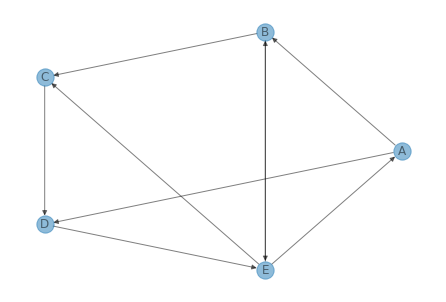

In [0]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
    for i, j in graph["edges"]: 
      adj_matr.loc[i,j] = 1
    ############### (END) YOUR CODE #################
    return adj_matr

In [0]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

A B C D E
A 0 1 0 1 0
B 0 0 1 0 1
C 0 0 0 1 0
D 0 0 0 0 1
E 1 1 1 0 0

In [0]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    for i,j in graph["edges"]:
      adj_list[i].append(j)
    
    ############### (END) YOUR CODE #################
    return adj_list

In [0]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}

# Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

### Q3 Tasks:

* __a) short response:__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?

* __b) short response:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) short response:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) code + short response:__ What is a "right stochastic matrix"? Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __e) code + short response:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. How many iterations does it take to converge? Which node is most 'central' (i.e. highest ranked)? Does this match your intuition? 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.

### Q3 Student Answers:
> __a)__ PageRank is the steady-state probability distribution of the Markov process underlying the random-surfer navigation model. Thus, it is a  its a stationary distribution of probabilities based on the popularity / number of relative clicks on each page in the web graph - a distribution that is achieved via the `power iteration` method after iterating over the state matrix several times (mimicking an infinite random walk). The stationary distribution can be interpreted as the proportion of time on average is spent at a specific state (page) during an infinitely long random walk. More intuitively, the PageRank metric measures the relative importance (over infinite time) of each node in the web graph - or the long range probability of a surfer clicking on a particular page. Pages that are linked more often and visited more frequently have a higher PageRank score. It is calculated as the sum of all the probabilities with which the surfer visited inbound links to the page. 

> __b)__ A Markov property is the memoryless property of a stochastic process. A stochastic process has the Markov property if the conditional probability distribution of future states of the process depends only upon the present state. In other words, the next state depends only on the current state and not on the sequence of events that preceded it. In the context of PageRank, the current page only depends on the previous page. It does not depend on the entire path that got the surfer to the current page.

> __c)__ Here, the N states represents all the web pages in the web graph. N x N represents all the possible state transitions of the web graph in the form of a matrix. The size of the transition matrix `Q` is calculated as `Q=D_inv x A` can be potentially very large if the web graph is large. Here `D_inv` is the inverse of the out degree matrix and `A` is the adjacency matrix.  

> __d)__ The right stochastic matrix is representing the transition matrix `Q`. The dimension of this matrix will always be N x N. The special property of this matrix is that its row wise sum is 1. The transition matrix is is representing the transition probabilities for a given node to every other node. Thus, for a given node (ie, row), its transition probabilities must sum to 1 since it has to transition to some other state (node) with definite probability. Note that here, by taking the inverse of the outdegree for a node, we are alloting equal probability of transition from the node to all its outlinks. 

> __e)__ We calculate the state vector for the pages at each iteration as implemented in [workbook 10](https://github.com/UCB-w261/main/blob/main/LiveSessionMaterials/wk10Demo_PageRank/master/demo10_workbook.ipynb). With this approach, it takes around 50 iterations to reach convergence (matching the exact values against the expected answer). We can implement this differently though, such that we multiply the state transition matrix by itself in each iteration. In this approach, ONLY at the end, we find the state vector by multiplying it with the final state transition matrix. If we use this approach, we reach convergence by iteration 6. Node E is the the most central (highest probability). This makes sense because it is possible to reach any node via node E.

In [0]:
# part d - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

Out[14]:

,A,B,C,D,E
A,0,1,0,1,0
B,0,0,1,0,1
C,0,0,0,1,0
D,0,0,0,0,1
E,1,1,1,0,0


In [0]:
# part d - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE ##################
out_degree = np.diag(np.sum(TOY_ADJ_MATR, axis=1))
inv_out_degree = np.linalg.inv(out_degree)
transition_matrix = np.dot(inv_out_degree, TOY_ADJ_MATR)
################ (END) YOUR CODE #################
print(transition_matrix)

[[0. 0.5 0. 0.5 0. ]
 [0. 0. 0.5 0. 0.5 ]
 [0. 0. 0. 1. 0. ]
 [0. 0. 0. 0. 1. ]
 [0.33333333 0.33333333 0.33333333 0. 0. ]]

In [0]:
# part e - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing inial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    state_vector = xInit
    for i in range(nIter):
      state_vector = np.dot(state_vector, tMatrix)
      if verbose:
        print("For iteration {}, the state_vector is".format(i+1))
        print(state_vector)
    
    if verbose:
      print("Finished all power iterations...")
      print("Printing final state vector")
      print(state_vector)
    
    ################ (END) YOUR CODE #################
    return state_vector

In [0]:
def power_iteration_alt(xInit, tMatrix, nIter, verbose = True):
  for i in range(nIter):
    tMatrix = np.dot(tMatrix, tMatrix)
    if verbose:
      print("For iteration {}, the tMatrix is".format(i+1))
      print(tMatrix)
      
  state_vector = np.dot(xInit, tMatrix)
  if verbose:
    print("Finished all power iterations...")
    print("Printing final state vector")
    print(state_vector)
    
  return state_vector
  

In [0]:
# part e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 50, verbose = False)
print(states)

[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]

In [0]:
print(power_iteration_alt(xInit, transition_matrix, 10, verbose = False))

[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]

__`Expected Output for part e:`__  
>Steady State Probabilities:
```
Node A: 0.10526316  
Node B: 0.15789474  
Node C: 0.18421053  
Node D: 0.23684211  
Node E: 0.31578947  
```

# Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code + short response:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3. What is wrong with what you see? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __b) short response:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem you described in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __c) short response:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Explain your reasoning briefly.

* __d) short response:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Explain your reasoning briefly.

* __e) short response:__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.

### Q4 Student Answers:
> __a)__ We see that E is a dangling node and has 0 outlinks (which implies that the transition matrix for node E (last row) will be invalid), due to which the transition matrix is full of NANs. Thus, we notice that the power iteration calculation leads to an invalid state vector because of this dangling node.  

> __b)__ As mentioned above, the dangling node is E which leads to an invalid transition matrix, and thus an invalid state vector. One fix to this problem is teleportation, which is the original idea of the page rank paper. We can replace the row corresponding to the dangling node (full of NANs) with a vector with all entries being `1/n`. This will have the effect of teleportation with equal probability so the next transition from node E would be equally redistributed amongst all nodes of the graph. This will allow us to come out of this black hole state E, thus allowing us to maintain the property of irreducibility - which is required for page rank to work.

> __c)__ A Markov chain (or our graph in this case) is said to be irreducible if its state space is a single communicating class; in other words, if it is possible to get to any state from any state in finite number of steps. The webgraph is not naturally irreducible. In the web, there are naturally plenty of "black hole pages" or "dangling pages" - pages that have no outlinks from their current page. Thus, if a random surfer reaches one of these pages, it will be impossible for them to navigate out of this page, thus making the web graph non-irreducible. The irreducible property of a graph is required to satisfy the "Perron-Frobenius Theorem" - which is needed for page rank formulation. 

> __d)__ A Markov chain (graph) is aperiodic if the greatest common divisor of all cycle lengths is 1. Expressed mathematically, `GCD{t: P(Xt = "A" | X0 = "A") > 0} = 1` ([source](https://www.youtube.com/watch?v=tByUQbJdt14)). In other words, there must not be any periodicity when starting from state `A` and coming back to state `A`. We should be able to reach back to state `A` (given we started there) in both odd and even number of steps (such that these 2 numbers are consecutive, ie, `2k` and `2k+1`). This is because `GCD(2k, 2k+1) = 1`. The natural web graph is not necessarily aperiodic. There could be sub graphs such that they form a peiodic cycle, such that we can only get back to page `A` (after starting from there) if we traverse the entire set of pages that lead us back to `A` (this sub graph has a fixed periodicity). The aperiodicity property of a graph is required to satisfy the "Perron-Frobenius Theorem" - which is needed for page rank formulation.

> __e)__ To get around the irreducibility problem, we need to introduce teleportation on the pages that are dangling. This ensures that we can get out of these "dangling pages" and reach any other page in the graph with equal probability, thus making it possible to reach to any node starting from any node (irreducible). To get around the aperiodicity problem, we can add a `loopback link` to any given page in the cycle that breaks the periodicity in the sub graph. This allows us to get back to a node in both even and odd number of steps, breaking periodicity.

In [0]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

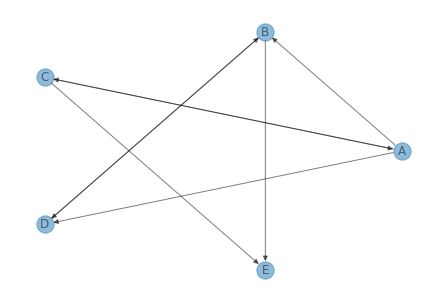

In [0]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################
# Get adj matrix 
TOY2_ADJ_MATR = get_adj_matr(TOY2_GRAPH)
# print(TOY2_ADJ_MATR)

# transition matrix
# cannot calculate the inverse of the outdegree as it gives an error (because E is dangling node), 
# thus we use another method to get the transition matrix  
# out_degree = np.diag(np.sum(TOY2_ADJ_MATR, axis=1))
# inv_out_degree = np.linalg.inv(out_degree)

tMatrix2 = TOY2_ADJ_MATR/np.sum(TOY2_ADJ_MATR.to_numpy(), axis=1, keepdims=True)
print(tMatrix2)

# state
states = power_iteration(xInit, tMatrix2, 10, verbose = False)
print(states)
################ (END) YOUR CODE #################

A B C D E
A 0.0 0.333333 0.333333 0.333333 0.0
B 0.0 0.000000 0.000000 0.500000 0.5
C 0.5 0.000000 0.000000 0.000000 0.5
D 0.0 1.000000 0.000000 0.000000 0.0
E NaN NaN NaN NaN NaN
[nan nan nan nan nan]

# About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

As in previous homeworks we'll be using a 2GB subset of this data, which is available to you in this dropbox folder: 
> https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

In [0]:
dbutils.fs.ls(DATA_PATH)

Out[23]: [FileInfo(path='dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt', name='all-pages-indexed-in.txt', size=2143300687),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt', name='all-pages-indexed-out.txt', size=2090459616),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/indices.txt', name='indices.txt', size=517438296),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/test_graph.txt', name='test_graph.txt', size=167)]

In [0]:
# open test_graph.txt file to see format (RUN THIS CELL AS IS)
with open('/dbfs/mnt/mids-w261/HW5/test_graph.txt', "r") as f_read:
  for line in f_read:
    print(line)

2	{'3': 1}

3	{'2': 2}

4	{'1': 1, '2': 1}

5	{'4': 3, '2': 1, '6': 1}

6	{'2': 1, '5': 2}

7	{'2': 1, '5': 1}

8	{'2': 1, '5': 1}

9	{'2': 1, '5': 1}

10	{'5': 1}

11	{'5': 2}

In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

In [0]:
# display testRDD (RUN THIS CELL AS IS)
testRDD.take(10)

Out[25]: ["2\t{'3': 1}",
 "3\t{'2': 2}",
 "4\t{'1': 1, '2': 1}",
 "5\t{'4': 3, '2': 1, '6': 1}",
 "6\t{'2': 1, '5': 2}",
 "7\t{'2': 1, '5': 1}",
 "8\t{'2': 1, '5': 1}",
 "9\t{'2': 1, '5': 1}",
 "10\t{'5': 1}",
 "11\t{'5': 2}"]

In [0]:
# display indexRDD (RUN THIS CELL AS IS)
indexRDD.take(10)

Out[26]: ['! $var = &quot;&quot;\t1\t1\t0',
 '! (CONFIG.SYS directive)\t2\t1\t1',
 '! (album)\t3\t12\t17',
 '! (disambiguation)\t4\t1\t20',
 '! -attention-\t5\t1\t0',
 '! Time Zone\t6\t1\t0',
 '!! (chess)\t7\t0\t1',
 '!! (disambiguation)\t8\t3\t0',
 '!!! (Chk Chk Chk)\t9\t1\t0',
 '!!! (album)\t10\t5\t15']

In [0]:
# display wikiRDD (RUN THIS CELL AS IS)
wikiRDD.take(10)

Out[27]: ["73\t{'14417532': 1}",
 "299\t{'4214575': 1}",
 "2552\t{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}",
 "2570\t{'983991': 1}",
 "2616\t{'9045350': 1}",
 "2711\t{'752887': 1}",
 "2818\t{'3534183': 1}",
 "2847\t{'3797918': 1}",
 "2892\t{'2893': 1}",
 "2921\t{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}"]

# Question 5: EDA part 1 (number of nodes)

As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q5 Tasks:
* __a) short response:__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) code + short response:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) short response:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:
> __a)__ The raw data seems to be in String format. If we look at the `testRDD` or the `wikiRDD`, the first value represents the source node ID. The second part represents a dictionary of neighbor nodes along with their edge weights. For example, we can have an entry like `node1: {node2: w12, node3: w13 }`. This implies that node 1 is connected to node 2 with edge weight w12, and node 1 is connected to node 3 with edge weight w13.  

> __b)__ We observe that the wikiRDD has 5781290 records. It is important to remember that the graph representation only consists of nodes that have outlinks. If a node has no outlinks, ie, its a "dangling node" - then it would not be represented in this record list. If the graph representation consisted of nodes with empty outlinks too, then taking the count would reveal all nodes in the graph. 

> __d)__ The number of dangling nodes are given by the total number of nodes - nodes with an outlink. This value is 15192277 - 5781290  = 9,410,987 dangling nodes

In [0]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
# 5781290
print(wikiRDD.count())

5781290

In [0]:
print(testRDD.collect())

["2\t{'3': 1}", "3\t{'2': 2}", "4\t{'1': 1, '2': 1}", "5\t{'4': 3, '2': 1, '6': 1}", "6\t{'2': 1, '5': 2}", "7\t{'2': 1, '5': 1}", "8\t{'2': 1, '5': 1}", "9\t{'2': 1, '5': 1}", "10\t{'5': 1}", "11\t{'5': 2}"]

In [0]:
# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############
    def combineAllNodesIntoList(entry):
      '''
      input: "2\t{'3': 1}"
      output: ['2', '3']
      '''
      import ast
      n1, dicStr = entry.split('\t')
      dic = ast.literal_eval(dicStr)
      return list(dic.keys()) + [str(n1)]
      
    totalCount = dataRDD.map(lambda x: combineAllNodesIntoList(x)) \
                        .flatMap(lambda x: x).distinct().count() 
                        
    ############## (END) YOUR CODE ###############   
    return totalCount

In [0]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 4.150876760482788 seconds.
Total Nodes: 11

In [0]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 370.39841747283936 seconds.
Total Nodes: 15192277

# Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:
* __a) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
 * count the out-degree of each non-dangling node and return the names of the top 10 pages with the most hyperlinks
 * find the average out-degree for all non-dangling nodes in the graph
 * take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
 
 
* __b) short response:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) short response:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others?
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:

> __b)__ In PageRank, we use the out degree of a node to calculate the page rank probability in the `hyperlink matrix` (the matrix associated with the 1-alpha term). We emit the probability from a node `n` as `(total_prob_node_n)/(out_degree_node_n)`  

> __c)__ Nodes with an outdegree of 0 are dangling nodes - ie, once a random surfer reaches here, it is not possible for them to come out of this state. This causes the graph to become non-irreducible. In PageRank, these are handled using a teleportation matrix. We take the incoming mass to the dangling node and we re-distribute the mass to all the other nodes of the graph with probability `m/|G|`. Here `m` represents the incoming probability mass to the dangling node, and `|G|` represents the size of the graph.

In [0]:
# part a - write your Spark job here (compute average in-degree, etc)
def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    ############## YOUR CODE HERE ###############\
    def parse(line):
      '''
      input: "1\t{'3': 1,'4': 10}"
      output: ['1', 2]
      '''
      node, dicStr = line.split('\t')
      # parse value as dictionary and emit length of dictionary, length represents out degree
      # we don't have to worry about unique outdegree nodes (in the value) because we are looking at a dictionary
      # all keys in a dictionary are unique by definition
      return (node, len(ast.literal_eval(dicStr)))
    
    # cache the RDD so it can be reused again
    parsedRDD = dataRDD.map(lambda x: parse(x)).cache()

    # sort by top 10 decreasing order of outdegree length
    top = parsedRDD.takeOrdered(10, key=lambda x: -x[1])
    
    # find the average outdegree by emitting the outdegree in a map call
    avgDegree = parsedRDD.map(lambda x: x[1]).mean()

    # sample without replacement
    sampledCounts = parsedRDD.map(lambda x: x[1]).takeSample(False, n)
    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

In [0]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])

... completed job in 0.6246891021728516 seconds
Average out-degree: 1.7
Top 10 nodes (by out-degree:)
 [('5', 3), ('4', 2), ('6', 2), ('7', 2), ('8', 2), ('9', 2), ('2', 1), ('3', 1), ('10', 1), ('11', 1)]

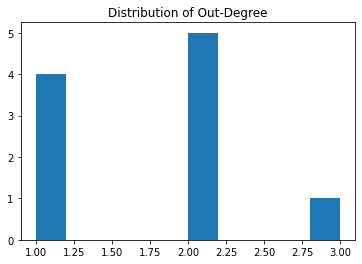

In [0]:
# part a - plot results from test file (RUN THIS CELL AS IS)
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
display(plt.show())

In [0]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)

print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])

... completed job in 232.37487888336182 seconds
Average out-degree: 24.58172086160741
Top 10 nodes (by out-degree:)
 [('7883280', 7132), ('7884831', 5877), ('6075450', 5875), ('6074992', 5855), ('7828359', 5839), ('7880980', 5692), ('1008643', 5598), ('7828391', 5597), ('7873008', 5573), ('7841582', 5530)]

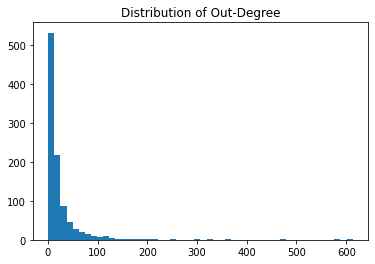

In [0]:
# part a - plot results from full file (RUN THIS CELL AS IS)
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
display(plt.show())

# Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code \\(N\\).

### Q7 Tasks:
* __a) short response:__ What is \\(N\\)? Use the analogy of the infinite random web-surfer to explain why we'll initialize each node's rank to \\(\frac{1}{N}\\). (i.e. what is the probabilistic interpretation of this choice?)

* __b) short response:__ Will it be more efficient to compute \\(N\\) before initializing records for each dangling node or after? Explain your reasoning.

* __c) code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __d) code:__ Run the provided code to confirm that your job in `part a` has a record for each node and that your should records match the format specified in the docstring and the count should match what you computed in question 5. [__`TIP:`__ _you might want to take a moment to write out what the expected output should be fore the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q7 Student Answers:

> __a)__ N is the total number of nodes in the graph. In PageRank, we aim to find the relative importance of one graph node (page) over another. Initially, we initialize all nodes of the graph to be visited with equal probability. This is the motivation to initialize the node's rank with `1/N`. The hope is that after convergence of page rank, we will get the true relative probabilities for each node. We also include our dangling nodes in this setting as we don't wish to discard them from our computation.

> __b)__ It will be more efficient to find N before initializing records for dangling nodes. The aim is to find all nodes in the graph (including the dangling nodes) in a single map reduce task as we did in Q5. Once we have this total value of N, we can initialize all nodes in the graph together via a map broadcast. This is better than having to do 2 passes of the data - one where we are interested in just the "keys" of records (ie, non-dangling nodes) and another where we are also interested in the record "values" (ie, dangling and non-dangling nodes).

In [0]:
# part c - job to initialize the graph (RUN THIS CELL AS IS)
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############

    ##### HELPERS ######## 
    def emitNodePayload(entry):
      '''
      input: "2\t{'3': 1, '4': 10}"
      output: ('2', (1/n, [kvp('3',1), kvp('4',10)]))
      '''
      import ast
      node, dicStr = entry.split('\t')
      edges = ast.literal_eval(dicStr)
      
      # n is already accessible here since it has been broadcasted
      # wt is a float
      wt = 1.0 * (1/n.value)
      
      # emit node and its payload
      yield (node, (wt, list(edges.items())))
      
      # for each neighbor of 'node', emit an empty list - this handles dangling nodes emission to get full graph 
      # non-dangling nodes are also emitted with empty list (can be later reduced via list join)
      for key in edges.keys():
        yield (key, (wt, []))
      
    def dedupeEdgeListValues(payload1, payload2):
      prob1, edgelist1 = payload1 
      prob2, edgelist2 = payload2
      # set removes repeated values from the 2 edge lists
      # list() converts the set back to list to preserve structure of overall payload
      # emit only prob1 since we don't want to combine 1/n probabilities
      return (prob1, list(set(edgelist1 + edgelist2)))
      
    ##### MAIN ########
    
    # brodcast total number of graph nodes
    # calculation below is from Q5
    n = sc.broadcast(count_nodes(dataRDD))
    
    graphRDD = dataRDD.flatMap(lambda x: emitNodePayload(x)).reduceByKey(lambda x, y: dedupeEdgeListValues(x, y)).cache()
    ############## (END) YOUR CODE ##############
    
    return graphRDD

In [0]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 0.40255188941955566 seconds.
Out[94]: [('4', (0.09090909090909091, [('2', 1), ('1', 1)])),
 ('1', (0.09090909090909091, [])),
 ('8', (0.09090909090909091, [('2', 1), ('5', 1)])),
 ('9', (0.09090909090909091, [('2', 1), ('5', 1)])),
 ('10', (0.09090909090909091, [('5', 1)])),
 ('2', (0.09090909090909091, [('3', 1)])),
 ('3', (0.09090909090909091, [('2', 2)])),
 ('5', (0.09090909090909091, [('2', 1), ('4', 3), ('6', 1)])),
 ('6', (0.09090909090909091, [('5', 2), ('2', 1)])),
 ('7', (0.09090909090909091, [('2', 1), ('5', 1)])),
 ('11', (0.09090909090909091, [('5', 2)]))]

In [0]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 457.58214592933655 seconds

In [0]:
# part c - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
print(f'First record: {wikiGraphRDD.take(1)}')
print(f'... initialization continued: {time.time() - start} seconds')

Total number of records: 15192277
First record: [('7145088', (6.582291778908455e-08, []))]
... initialization continued: 1382.7091114521027 seconds

# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/PR-illustrated.png?raw=true' width=50%>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) short response:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$

* __b) short response:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) short response:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  * 
  
   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:

> __a)__ There is a `1/|G|` chance of landing at any particular page, where `|G|` is the number of nodes in the graph. Probability $\alpha$ is the likelihood that the random surfer executes a random jump (also called the teleportation factor), and 1-$\alpha$ is the probability that the random surfer follows a hyperlink (also called the damping factor).


> __b)__ `m` is the dangling node PageRank mass that is "lost" due to being "black-holed" within the dangling node. This is the mass we need to distribute back into the graph across all the nodes to preserve our page rank calculations, and avoid getting "stuck" at the dangline node. We do this redistribution by dividing the mass by |G| (length of the graph) and adding it to the original page rank probability of the node (in the damping term of PageRank caclulation). Note that non-dangling nodes will have `m=0`, so they will only contribute their PageRank mass. 

> __c)__ Total mass should be 1 across the graph after each iteration (sum of page rank probabilities is 1, and gets redistributed each iteration).

In [0]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [0]:
#############################################################################
# CODE THAT WAS SENT TO VINICIO
#############################################################################

# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # get total node count 
    n_bc = sc.broadcast(graphInitRDD.count())

    # initialize accumulators for dangling mass & total mass
    #mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    #totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ############## YOUR CODE HERE ###############
    
    # write your helper functions here, 
    # please document the purpose of each clearly 
    # for reference, the master solution has 5 helper functions.

    # calculate total weight of all of the edges 
    def totalWeight(edges):
      totWeight = 0 
      for i, j in edges:
        totWeight += j
      return totWeight
    
    # calculate 1/n * weight/totalWeight and return (edge, (calculation, []))
    # not sure what this is called/what a good name is 
    def neighborNodeScore(x):
      sourceNode, neighbors, totWeight = x
      yield (sourceNode, (0,neighbors[1]))
      for neighbor, weight in neighbors[1]:
        yield (neighbor, (neighbors[0]*weight/totWeight, []))
          
            
    # write your main Spark Job here (including the for loop to iterate)
    # for reference, the master solution is 21 lines including comments & whitespace
    print(maxIter)
    for i in range(maxIter):
      # initialize accumulators for dangling mass & total mass
      mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
      totAccum = sc.accumulator(0.0, FloatAccumulatorParam())

      # get dangling node mass 
      graphInitRDD.filter(lambda x: x[1][1] == []).foreach(lambda x: mmAccum.add(x[1][0]))
      #mmAccum.add(graphInitRDD.filter(lambda x: x[1][1] == []).collect()[0][1][0])
      #mmAccum_bc = sc.broadcast(mmAccum.value)
      mmAccum_bc = mmAccum.value

      # mapreduce 
      graphInitRDD = graphInitRDD.map(lambda x: (x[0], x[1], totalWeight(x[1][1]))) \
                                  .flatMap(lambda x: (neighborNodeScore(x))) \
                                  .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])).cache()
      
      
      graphInitRDD = graphInitRDD.reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])).cache()
    
      graphInitRDD = graphInitRDD.mapValues(lambda x: (a.value/n_bc.value + d.value*(mmAccum_bc/n_bc.value+x[0]), x[1]))
      
      # check if totAccum is equal to 1 
      graphInitRDD.foreach(lambda x: totAccum.add(x[1][0]))
      print(i, " check total accumulator: ", totAccum.value)
      #print("dangling mass ", mmAccum_bc)
    
    steadyStateRDD = graphInitRDD.map(lambda x: (x[0], x[1][0]))
    #print(graphInitRDD.collect())
    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

In [0]:
# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # get total node count 
    n_bc = sc.broadcast(graphInitRDD.count())

    # initialize accumulators for dangling mass & total mass
    #mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    #totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ############## YOUR CODE HERE ###############
    
    # write your helper functions here, 
    # please document the purpose of each clearly 
    # for reference, the master solution has 5 helper functions.

    # calculate total weight of all of the edges 
    def totalWeight(edges):
      totWeight = 0 
      for i, j in edges:
        totWeight += j
      return totWeight
    
    # calculate 1/n * weight/totalWeight and return (edge, (calculation, []))
    # not sure what this is called/what a good name is 
    def neighborNodeScore(x):
      sourceNode, neighbors, totWeight = x
      yield (sourceNode, (0,neighbors[1]))
      for neighbor, weight in neighbors[1]:
        yield (neighbor, (neighbors[0]*weight/totWeight, []))
        
    def test(x):
      if x[1][1] == []:
        return True
      else:
        return False
          
            
    # write your main Spark Job here (including the for loop to iterate)
    # for reference, the master solution is 21 lines including comments & whitespace
    print(maxIter)
    for i in range(maxIter):
      # initialize accumulators for dangling mass & total mass
      mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
      totAccum = sc.accumulator(0.0, FloatAccumulatorParam())

      # TEST PRINT 
      #data = graphInitRDD.collect()
      #for item in data: 
        #print("before graphInitRDD.filter", item)
        
      # get dangling node mass 
      # SOMETHING WEIRD HAPPENS HERE. WE LOSE MASS 
      graphInitRDD.filter(test).foreach(lambda x: mmAccum.add(x[1][0]))
      #graphInitRDD.filter(test).map(lambda x: x[1][0]).foreach(lambda x: mmAccum.add(x))
      #mmAccum.add(graphInitRDD.filter(lambda x: x[1][1] == []).collect()[0][1][0])
      #mmAccum_bc = sc.broadcast(mmAccum.value)
      mmAccum_bc = mmAccum.value
      
      print("dangling mass ", mmAccum_bc)
      
      
      # TEST PRINTS
      data = graphInitRDD.collect()
      for item in data: 
        print("** after graphInitRDD.filter **", item)

      
      # mapreduce 
      graphInitRDD = graphInitRDD.map(lambda x: (x[0], x[1], totalWeight(x[1][1]))) \
                                  .flatMap(lambda x: (neighborNodeScore(x))) \
      

      # TEST PRINTS
      data = graphInitRDD.collect()
      for item in data: 
        print("after weight calculation", item)
      
      graphInitRDD = graphInitRDD.reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])).cache()
    
      graphInitRDD = graphInitRDD.mapValues(lambda x: (a.value/n_bc.value + d.value*(mmAccum_bc/n_bc.value+x[0]), x[1]))
      
      # check if totAccum is equal to 1 
      graphInitRDD.foreach(lambda x: totAccum.add(x[1][0]))
      print(i, " check total accumulator: ", totAccum.value)
      #print("dangling mass ", mmAccum_bc)
    
    steadyStateRDD = graphInitRDD.map(lambda x: (x[0], x[1][0]))
    print(graphInitRDD.collect())
    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

In [0]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 2
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = False)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])

2
dangling mass 0.09090909090909091
** after graphInitRDD.filter ** ('4', (0.09090909090909091, [('1', 1), ('2', 1)]))
** after graphInitRDD.filter ** ('1', (0.09090909090909091, []))
** after graphInitRDD.filter ** ('8', (0.09090909090909091, [('2', 1), ('5', 1)]))
** after graphInitRDD.filter ** ('9', (0.09090909090909091, [('2', 1), ('5', 1)]))
** after graphInitRDD.filter ** ('10', (0.09090909090909091, [('5', 1)]))
** after graphInitRDD.filter ** ('2', (0.09090909090909091, [('3', 1)]))
** after graphInitRDD.filter ** ('3', (0.09090909090909091, [('2', 2)]))
** after graphInitRDD.filter ** ('5', (0.09090909090909091, [('4', 3), ('2', 1), ('6', 1)]))
** after graphInitRDD.filter ** ('6', (0.09090909090909091, [('2', 1), ('5', 2)]))
** after graphInitRDD.filter ** ('7', (0.09090909090909091, [('2', 1), ('5', 1)]))
** after graphInitRDD.filter ** ('11', (0.09090909090909091, [('5', 2)]))
after weight calculation ('4', (0, [('1', 1), ('2', 1)]))
after weight calculation ('1', (0.045454545454545456, []))
after weight calculation ('2', (0.045454545454545456, []))
after weight calculation ('1', (0, []))
after weight calculation ('8', (0, [('2', 1), ('5', 1)]))
after weight calculation ('2', (0.045454545454545456, []))
after weight calculation ('5', (0.045454545454545456, []))
after weight calculation ('9', (0, [('2', 1), ('5', 1)]))
after weight calculation ('2', (0.045454545454545456, []))
after weight calculation ('5', (0.045454545454545456, []))
after weight calculation ('10', (0, [('5', 1)]))
after weight calculation ('5', (0.09090909090909091, []))
after weight calculation ('2', (0, [('3', 1)]))
after weight calculation ('3', (0.09090909090909091, []))
after weight calculation ('3', (0, [('2', 2)]))
after weight calculation ('2', (0.09090909090909091, []))
after weight calculation ('5', (0, [('4', 3), ('2', 1), ('6', 1)]))
after weight calculation ('4', (0.05454545454545454, []))
after weight calculation ('2', (0.01818181818181818, []))
after weight calculation ('6', (0.01818181818181818, []))
after weight calculation ('6', (0, [('2', 1), ('5', 2)]))
after weight calculation ('2', (0.030303030303030304, []))
after weight calculation ('5', (0.06060606060606061, []))
after weight calculation ('7', (0, [('2', 1), ('5', 1)]))
after weight calculation ('2', (0.045454545454545456, []))
after weight calculation ('5', (0.045454545454545456, []))
after weight calculation ('11', (0, [('5', 2)]))
after weight calculation ('5', (0.09090909090909091, []))
0 check total accumulator: 1.0
dangling mass 0.059297520661157024
** after graphInitRDD.filter ** ('4', (0.0645820811419985, [('1', 1), ('2', 1)]))
** after graphInitRDD.filter ** ('1', (0.05685480841472577, []))
** after graphInitRDD.filter ** ('8', (0.018218444778362132, [('2', 1), ('5', 1)]))
** after graphInitRDD.filter ** ('9', (0.018218444778362132, [('2', 1), ('5', 1)]))
** after graphInitRDD.filter ** ('10', (0.018218444778362132, [('5', 1)]))
** after graphInitRDD.filter ** ('2', (0.29124874780866516, [('3', 1)]))
** after graphInitRDD.filter ** ('5', (0.34018814174805906, [('4', 3), ('2', 1), ('6', 1)]))
** after graphInitRDD.filter ** ('3', (0.09549117205108941, [('2', 2)]))
** after graphInitRDD.filter ** ('6', (0.03367299023290759, [('2', 1), ('5', 2)]))
** after graphInitRDD.filter ** ('7', (0.018218444778362132, [('2', 1), ('5', 1)]))
** after graphInitRDD.filter ** ('11', (0.018218444778362132, [('5', 2)]))
after weight calculation ('4', (0, [('1', 1), ('2', 1)]))
after weight calculation ('1', (0.03229104057099925, []))
after weight calculation ('2', (0.03229104057099925, []))
after weight calculation ('1', (0, []))
after weight calculation ('8', (0, [('2', 1), ('5', 1)]))
after weight calculation ('2', (0.009109222389181066, []))
after weight calculation ('5', (0.009109222389181066, []))
after weight calculation ('9', (0, [('2', 1), ('5', 1)]))
after weight calculation ('2', (0.009109222389181066, []))
after weight calculation ('5', (0.009109222389181066, []))
after w

__`expected results for the test graph:`__
```
[(2, 0.3620640495978871),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (8, 0.01692511778009981),
 (10, 0.01692511778009981),
 (7, 0.01692511778009981),
 (9, 0.01692511778009981),
 (11, 0.01692511778009981)]
```

In [0]:
# part d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTE: wikiGraphRDD should have been computed & cached above!
nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
full_results.takeOrdered(20, key=lambda x: - x[1])

10
0 check total accumulator: 0.9999999999744142
1 check total accumulator: 0.9661212109735757
2 check total accumulator: 0.9585947532083497
3 check total accumulator: 0.9598822671632554
4 check total accumulator: 0.9642498448957588

In [0]:
top_20 = full_results.takeOrdered(20, key=lambda x: - x[1])

In [0]:
# Save the top_20 results to disc for use later. So you don't have to rerun everything if you restart the cluster.


In [0]:
# view record from indexRDD (RUN THIS CELL AS IS)
# title\t indx\t inDeg\t outDeg
indexRDD.take(1)

In [0]:
# map indexRDD to new format (index, name) (RUN THIS CELL AS IS)
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [0]:
# see new format (RUN THIS CELL AS IS)
namesKV_RDD.take(2)

# OPTIONAL
### The rest of this notebook is optional and doesn't count toward your grade.
The indexRDD we created earlier from the indices.txt file contains the titles of the pages and thier IDs.

* __a) code:__ Join this dataset with your top 20 results.
* __b) code:__ Print the results

## Join with indexRDD and print pretty

In [0]:
# part a
joinedWithNames = None
############## YOUR CODE HERE ###############

############## END YOUR CODE ###############

In [0]:
# part b
# Feel free to modify this cell to suit your implementation, but please keep the formatting and sort order.
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in joinedWithNames:
    print ("{:6f}\t| {:10d}\t| {}".format(r[1][1],r[0],r[1][0]))

## OPTIONAL - GraphFrames
GraphFrames is a graph library which is built on top of the Spark DataFrames API.

* __a) code:__ Using the same dataset, run the graphframes implementation of pagerank.
* __b) code:__ Join the top 20 results with indices.txt and display in the same format as above.
* __c) short answer:__ Compare your results with the results from graphframes.

__NOTE:__ Feel free to create as many code cells as you need. Code should be clear and concise - do not include your scratch work. Comment your code if it's not self annotating.

In [0]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from graphframes import *
from pyspark.sql import functions as F

In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

### You will need to generate vertices (v) and edges (e) to feed into the graph below. 
Use as many cells as you need for this task.

In [0]:
# Create a GraphFrame
from graphframes import *
g = GraphFrame(v, e)


In [0]:
# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.15, maxIter=10)

In [0]:
start = time.time()
top_20 = results.vertices.orderBy(F.desc("pagerank")).limit(20)
print(f'... completed job in {time.time() - start} seconds.')

In [0]:
%%time
top_20.show()

### Run the cells below to join the results of the graphframes pagerank algorithm with the names of the nodes.

In [0]:
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [0]:
namesKV_DF = namesKV_RDD.toDF()

In [0]:
namesKV_DF = namesKV_DF.withColumnRenamed('_1','id')
namesKV_DF = namesKV_DF.withColumnRenamed('_2','title')
namesKV_DF.take(1)

In [0]:
resultsWithNames = namesKV_DF.join(top_20, namesKV_DF.id==top_20.id).orderBy(F.desc("pagerank")).collect()

In [0]:
# TODO: use f' for string formatting
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in resultsWithNames:
    print ("{:6f}\t| {:10s}\t| {}".format(r[3],r[2],r[1]))

### Congratulations, you have completed HW5! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform